In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Performance
from time import time

In [3]:
# Machine Learning
from sklearn.linear_model import LogisticRegression

In [4]:
# Helper
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score

# Preliminaries

In [5]:
# Load the Data
train = pd.read_csv('input/train2.csv')
test = pd.read_csv('input/test2.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill
0,1,0,3,1,0,1,0,22,7.2500
1,2,1,1,1,0,0,1,38,71.2833
2,3,1,3,0,0,0,0,26,7.9250
3,4,1,1,1,0,0,0,35,53.1000
4,5,0,3,0,0,1,0,35,8.0500


# Feature engineering
Insights pulled from visualization and exploration notebook

In [7]:
def createNewCol(boolx):
    featx = []
    for i in range(len(boolx)):
        if boolx[i]:
            featx.append(1) 
        else:
            featx.append(0) 

    return featx

In [33]:
# (1) children younger than 18 in the first or second class predominantly survive
bool1 = (train['AgeFill'] < 18) & (train['Pclass'] < 3)
bool1t = (test['AgeFill'] < 18) & (test['Pclass'] < 3)
print(sum(bool1))

train["kidHighClass"] = createNewCol(bool1)
test["kidHighClass"] = createNewCol(bool1t)

35


In [34]:
# (2) mother's with one child in first or second class predominantly survive
bool2 = (train['AgeFill'] > 18) & (train['Parch'] == 1) & (train['Pclass'] < 3) & (train['Gender'] == 0)
bool2t = (test['AgeFill'] > 18) & (test['Parch'] == 1) & (test['Pclass'] < 3) & (test['Gender'] == 0)
print(sum(bool2))

train["momHighClass"] = createNewCol(bool2)
test["momHighClass"] = createNewCol(bool2t)

26


In [10]:
train[0:20]

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,kidsHighClass,momsHighClass
0,1,0,3,1,0,1,0,22.0,7.2500,0,0
1,2,1,1,1,0,0,1,38.0,71.2833,0,0
2,3,1,3,0,0,0,0,26.0,7.9250,0,0
3,4,1,1,1,0,0,0,35.0,53.1000,0,0
4,5,0,3,0,0,1,0,35.0,8.0500,0,0
5,6,0,3,0,0,1,2,25.0,8.4583,0,0
6,7,0,1,0,0,1,0,54.0,51.8625,0,0
7,8,0,3,3,1,1,0,2.0,21.0750,0,0
8,9,1,3,0,2,0,0,27.0,11.1333,0,0
9,10,1,2,1,0,0,1,14.0,30.0708,1,0


In [11]:
# create hold-out set

features = list(train.columns.values)[2::]
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

# Data exploration

In [12]:
X_train.groupby(y_train).mean()

,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,kidsHighClass,momsHighClass
Survived,,,,,,,,,
0,2.524272,0.567961,0.315534,0.861650,0.300971,29.832524,22.205915,0.004854,0.002427
1,1.976378,0.460630,0.452756,0.334646,0.437008,27.381260,48.353331,0.094488,0.062992


In [13]:
X_train.groupby('Port').mean()

,Pclass,SibSp,Parch,Gender,AgeFill,FareFill,kidsHighClass,momsHighClass
Port,,,,,,,,
0,2.359343,0.583162,0.404517,0.691992,28.939261,26.129669,0.043121,0.026694
1,1.878049,0.390244,0.349593,0.569106,30.056260,64.742957,0.040650,0.032520
2,2.892857,0.339286,0.089286,0.589286,25.991071,13.250895,0.000000,0.000000


# Data visualization 
## for more visualizations see 'Visualization and exploration' notebook

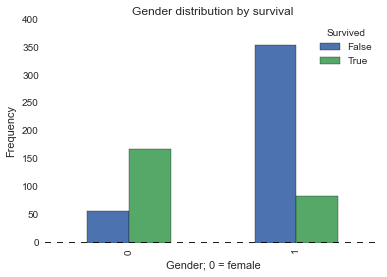

In [14]:
pd.crosstab(X_train.Gender, y_train.astype(bool)).plot(kind='bar')
plt.title('Gender distribution by survival')
plt.xlabel('Gender; 0 = female')
plt.ylabel('Frequency')

In [15]:
# null accuracy
null_accuracy = train.Survived.value_counts().max()/len(train.Survived)
print(null_accuracy)

0.617547806524


# Feature selection

In [40]:
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k = 4)
X_train2 = ch2.fit_transform(X_train, y_train)
# ch2.get_feature_names()
X_train2[0:10]


array([[  0.    ,  21.    ,   7.65  ,   0.    ],
       [  1.    ,  25.    ,   7.75  ,   0.    ],
       [  1.    ,  33.    ,   8.6625,   0.    ],
       [  0.    ,  33.    ,  15.85  ,   0.    ],
       [  1.    ,  25.    ,   6.8583,   0.    ],
       [  0.    ,  49.    ,  76.7292,   0.    ],
       [  0.    ,   0.75  ,  19.2583,   0.    ],
       [  1.    ,  58.    ,  29.7   ,   0.    ],
       [  1.    ,  25.    ,   7.7333,   0.    ],
       [  1.    ,  48.    ,  76.7292,   0.    ]])

In [41]:
predictors = list(X_train.columns.values[ch2.get_support()])
print(predictors)

['Gender', 'AgeFill', 'FareFill', 'kidsHighClass']


# Logistic regression

*penalty* = 'l2' (specify the norm used in penalization)

*C* = 1.0 (inverse of regularization strength; smaller values specify stronger regularization)

*random_state* = None (seed of the pseudo random number generator to use when shuffling the data)

In [24]:
# Initialize our algorithm
alg = LogisticRegression()

# Train the algorithm using all the training data
# start = time()
# # alg.fit(train[predictors], train["Survived"])
# print("LogisticReg Training finished in %.2f s" % (time() - start))

In [25]:
# Basic Evaluation on Training Set
start = time()
train_pred = cross_val_predict(alg, X_train[predictors], y_train, cv=10)
print("LogisticReg Evaluation finished in %.2f s" % (time() - start))

LogisticReg Evaluation finished in 0.04 s


In [26]:
# Display Accuracy
print("Accuracy: ", accuracy_score(y_train, train_pred))

Accuracy:  0.798798798799


In [27]:
# running fit method results in same accuracy as cross-val-predict
alg.fit(X_train[predictors], y_train)
print("Accuracy: ", accuracy_score(y_train, train_pred))

Accuracy:  0.798798798799


# Model evaluation

In [28]:
# Make predictions for hold-out set.
holdout_pred = alg.predict(X_test[predictors])
print("Accuracy: ", accuracy_score(y_test, holdout_pred))

Accuracy:  0.789237668161


In [29]:
# Make predictions for hold-out set using cross-val.
holdout_pred2 = cross_val_predict(alg, X_test[predictors], y_test, cv=10)
print("Accuracy: ", accuracy_score(y_test, holdout_pred2))

Accuracy:  0.811659192825


In [30]:
holdout_pred[0:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1], dtype=int64)

In [31]:
holdout_pred2[0:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1], dtype=int64)

In [35]:
# Make predictions for test set.
test_pred = alg.predict(test[predictors])

In [36]:
test_pred[0:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [37]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_pred
    })

# Any files you save will be available in the output tab below
submission.to_csv('submission.csv', index=False)